# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

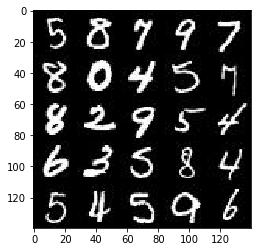

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

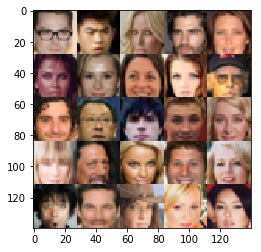

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels), 
                                 name='input_real')
    inputs_z = tf.placeholder(tf.float32, 
                              (None, z_dim), 
                              name='input_z')
    learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
       
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
  
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1744... Generator Loss: 2.2137
Epoch 1/2... Discriminator Loss: 0.1806... Generator Loss: 7.9444
Epoch 1/2... Discriminator Loss: 0.2287... Generator Loss: 5.1646
Epoch 1/2... Discriminator Loss: 0.0525... Generator Loss: 5.3997
Epoch 1/2... Discriminator Loss: 3.4874... Generator Loss: 0.0340
Epoch 1/2... Discriminator Loss: 0.0778... Generator Loss: 3.1841
Epoch 1/2... Discriminator Loss: 0.9688... Generator Loss: 0.5826
Epoch 1/2... Discriminator Loss: 0.2850... Generator Loss: 7.9047
Epoch 1/2... Discriminator Loss: 0.0918... Generator Loss: 2.6310
Epoch 1/2... Discriminator Loss: 0.2792... Generator Loss: 3.1055


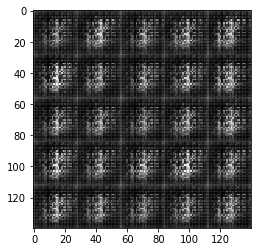

Epoch 1/2... Discriminator Loss: 0.7373... Generator Loss: 7.0365
Epoch 1/2... Discriminator Loss: 0.2726... Generator Loss: 2.2989
Epoch 1/2... Discriminator Loss: 0.2445... Generator Loss: 2.5640
Epoch 1/2... Discriminator Loss: 0.1963... Generator Loss: 2.8170
Epoch 1/2... Discriminator Loss: 0.1316... Generator Loss: 3.6038
Epoch 1/2... Discriminator Loss: 0.4311... Generator Loss: 1.6366
Epoch 1/2... Discriminator Loss: 0.2495... Generator Loss: 2.0962
Epoch 1/2... Discriminator Loss: 0.1358... Generator Loss: 3.3212
Epoch 1/2... Discriminator Loss: 0.1040... Generator Loss: 3.2848
Epoch 1/2... Discriminator Loss: 0.1765... Generator Loss: 2.4471


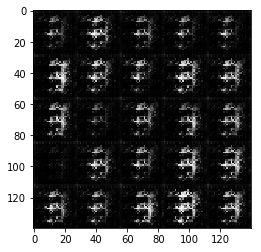

Epoch 1/2... Discriminator Loss: 0.1432... Generator Loss: 3.9256
Epoch 1/2... Discriminator Loss: 0.0855... Generator Loss: 3.5258
Epoch 1/2... Discriminator Loss: 0.3047... Generator Loss: 2.0984
Epoch 1/2... Discriminator Loss: 0.1870... Generator Loss: 6.8492
Epoch 1/2... Discriminator Loss: 0.0900... Generator Loss: 3.1183
Epoch 1/2... Discriminator Loss: 0.1346... Generator Loss: 2.8677
Epoch 1/2... Discriminator Loss: 0.1689... Generator Loss: 3.0960
Epoch 1/2... Discriminator Loss: 0.0474... Generator Loss: 4.1807
Epoch 1/2... Discriminator Loss: 0.1434... Generator Loss: 4.4430
Epoch 1/2... Discriminator Loss: 0.3875... Generator Loss: 13.3841


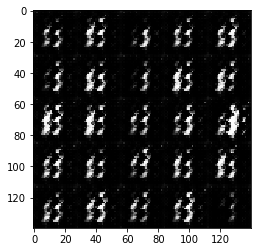

Epoch 1/2... Discriminator Loss: 0.1626... Generator Loss: 2.8166
Epoch 1/2... Discriminator Loss: 0.1761... Generator Loss: 2.6280
Epoch 1/2... Discriminator Loss: 0.1015... Generator Loss: 2.9419
Epoch 1/2... Discriminator Loss: 0.2435... Generator Loss: 3.0223
Epoch 1/2... Discriminator Loss: 0.0912... Generator Loss: 6.3668
Epoch 1/2... Discriminator Loss: 0.1843... Generator Loss: 2.1832
Epoch 1/2... Discriminator Loss: 0.2203... Generator Loss: 6.1635
Epoch 1/2... Discriminator Loss: 0.2861... Generator Loss: 3.6211
Epoch 1/2... Discriminator Loss: 0.1851... Generator Loss: 2.7818
Epoch 1/2... Discriminator Loss: 0.0812... Generator Loss: 3.5479


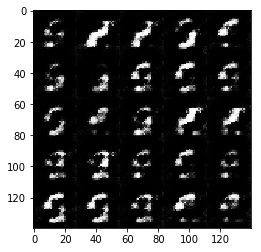

Epoch 1/2... Discriminator Loss: 0.3657... Generator Loss: 2.0864
Epoch 1/2... Discriminator Loss: 0.1091... Generator Loss: 3.3250
Epoch 1/2... Discriminator Loss: 0.3929... Generator Loss: 5.4816
Epoch 1/2... Discriminator Loss: 0.1742... Generator Loss: 2.4276
Epoch 1/2... Discriminator Loss: 0.2596... Generator Loss: 3.2145
Epoch 1/2... Discriminator Loss: 0.1817... Generator Loss: 2.8932
Epoch 1/2... Discriminator Loss: 0.3820... Generator Loss: 5.7207
Epoch 1/2... Discriminator Loss: 0.2312... Generator Loss: 2.3918
Epoch 1/2... Discriminator Loss: 0.1436... Generator Loss: 3.7367
Epoch 1/2... Discriminator Loss: 0.2282... Generator Loss: 5.1495


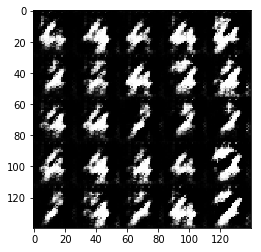

Epoch 1/2... Discriminator Loss: 0.3370... Generator Loss: 2.7632
Epoch 1/2... Discriminator Loss: 0.2128... Generator Loss: 2.6957
Epoch 1/2... Discriminator Loss: 0.4726... Generator Loss: 5.4841
Epoch 1/2... Discriminator Loss: 0.1800... Generator Loss: 2.9058
Epoch 1/2... Discriminator Loss: 0.1726... Generator Loss: 2.8327
Epoch 1/2... Discriminator Loss: 0.5778... Generator Loss: 6.2326
Epoch 1/2... Discriminator Loss: 0.0763... Generator Loss: 3.3263
Epoch 1/2... Discriminator Loss: 0.1389... Generator Loss: 3.7331
Epoch 1/2... Discriminator Loss: 0.4282... Generator Loss: 1.9080
Epoch 1/2... Discriminator Loss: 0.2195... Generator Loss: 3.2136


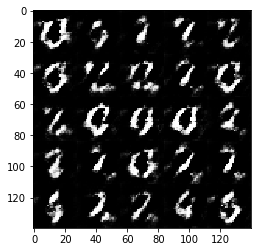

Epoch 1/2... Discriminator Loss: 0.5468... Generator Loss: 2.0841
Epoch 1/2... Discriminator Loss: 0.3977... Generator Loss: 2.0781
Epoch 1/2... Discriminator Loss: 0.5314... Generator Loss: 1.6489
Epoch 1/2... Discriminator Loss: 0.1852... Generator Loss: 2.6106
Epoch 1/2... Discriminator Loss: 0.3647... Generator Loss: 2.3248
Epoch 1/2... Discriminator Loss: 0.8394... Generator Loss: 1.0514
Epoch 1/2... Discriminator Loss: 0.7354... Generator Loss: 1.8641
Epoch 1/2... Discriminator Loss: 0.3340... Generator Loss: 1.9760
Epoch 1/2... Discriminator Loss: 0.2578... Generator Loss: 2.4957
Epoch 1/2... Discriminator Loss: 0.4608... Generator Loss: 5.1024


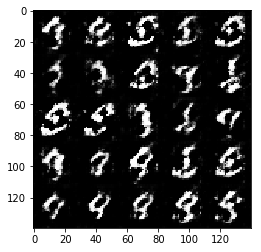

Epoch 1/2... Discriminator Loss: 0.4443... Generator Loss: 2.0846
Epoch 1/2... Discriminator Loss: 0.4452... Generator Loss: 4.0069
Epoch 1/2... Discriminator Loss: 0.7268... Generator Loss: 1.0027
Epoch 1/2... Discriminator Loss: 0.5911... Generator Loss: 2.2061
Epoch 1/2... Discriminator Loss: 0.9158... Generator Loss: 3.5356
Epoch 1/2... Discriminator Loss: 0.4720... Generator Loss: 1.7068
Epoch 1/2... Discriminator Loss: 0.6435... Generator Loss: 1.2429
Epoch 1/2... Discriminator Loss: 0.4234... Generator Loss: 2.7799
Epoch 1/2... Discriminator Loss: 0.4327... Generator Loss: 2.1565
Epoch 1/2... Discriminator Loss: 0.3148... Generator Loss: 2.0536


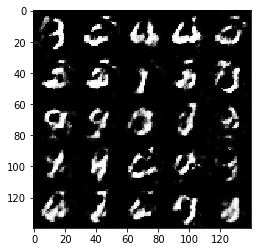

Epoch 1/2... Discriminator Loss: 0.4264... Generator Loss: 2.1978
Epoch 1/2... Discriminator Loss: 0.4362... Generator Loss: 2.5199
Epoch 1/2... Discriminator Loss: 0.8234... Generator Loss: 0.8681
Epoch 1/2... Discriminator Loss: 0.5194... Generator Loss: 2.3647
Epoch 1/2... Discriminator Loss: 0.5043... Generator Loss: 2.9729
Epoch 1/2... Discriminator Loss: 0.7305... Generator Loss: 1.2964
Epoch 1/2... Discriminator Loss: 0.7992... Generator Loss: 3.1231
Epoch 1/2... Discriminator Loss: 0.7256... Generator Loss: 1.0203
Epoch 1/2... Discriminator Loss: 0.5630... Generator Loss: 1.6410
Epoch 1/2... Discriminator Loss: 1.0941... Generator Loss: 0.6280


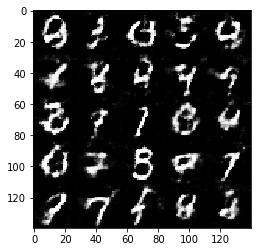

Epoch 1/2... Discriminator Loss: 0.7369... Generator Loss: 1.1266
Epoch 1/2... Discriminator Loss: 0.6651... Generator Loss: 1.2381
Epoch 1/2... Discriminator Loss: 0.6109... Generator Loss: 1.5043
Epoch 1/2... Discriminator Loss: 0.6292... Generator Loss: 1.4349
Epoch 1/2... Discriminator Loss: 0.6871... Generator Loss: 1.5039
Epoch 1/2... Discriminator Loss: 0.6600... Generator Loss: 1.4419
Epoch 1/2... Discriminator Loss: 0.5072... Generator Loss: 1.4611
Epoch 1/2... Discriminator Loss: 0.5707... Generator Loss: 1.2821
Epoch 1/2... Discriminator Loss: 1.0425... Generator Loss: 0.8062
Epoch 1/2... Discriminator Loss: 0.5556... Generator Loss: 1.6118


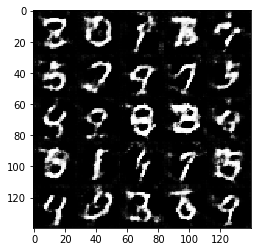

Epoch 1/2... Discriminator Loss: 0.8164... Generator Loss: 1.4979
Epoch 1/2... Discriminator Loss: 0.7117... Generator Loss: 2.1528
Epoch 1/2... Discriminator Loss: 1.0615... Generator Loss: 0.6592
Epoch 1/2... Discriminator Loss: 0.8205... Generator Loss: 1.7971
Epoch 1/2... Discriminator Loss: 0.5644... Generator Loss: 1.9192
Epoch 1/2... Discriminator Loss: 0.6747... Generator Loss: 2.1802
Epoch 1/2... Discriminator Loss: 0.6561... Generator Loss: 1.4355
Epoch 1/2... Discriminator Loss: 1.0588... Generator Loss: 0.5984
Epoch 1/2... Discriminator Loss: 0.7868... Generator Loss: 1.9782
Epoch 1/2... Discriminator Loss: 0.7846... Generator Loss: 2.6332


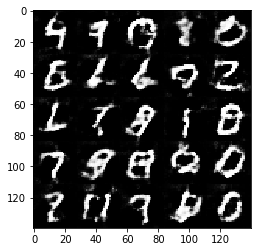

Epoch 1/2... Discriminator Loss: 0.6217... Generator Loss: 1.2078
Epoch 1/2... Discriminator Loss: 0.5951... Generator Loss: 1.2852
Epoch 1/2... Discriminator Loss: 0.5277... Generator Loss: 1.9269
Epoch 1/2... Discriminator Loss: 0.7628... Generator Loss: 1.1999
Epoch 1/2... Discriminator Loss: 1.0279... Generator Loss: 0.6597
Epoch 1/2... Discriminator Loss: 0.6978... Generator Loss: 0.9893
Epoch 1/2... Discriminator Loss: 0.5862... Generator Loss: 1.3563
Epoch 1/2... Discriminator Loss: 1.1052... Generator Loss: 3.3662
Epoch 1/2... Discriminator Loss: 0.7333... Generator Loss: 1.8126
Epoch 1/2... Discriminator Loss: 1.2402... Generator Loss: 0.5553


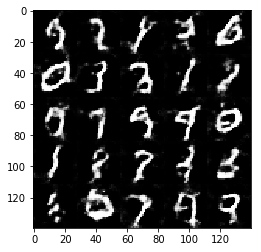

Epoch 1/2... Discriminator Loss: 0.6236... Generator Loss: 1.9173
Epoch 1/2... Discriminator Loss: 0.6006... Generator Loss: 2.3397
Epoch 1/2... Discriminator Loss: 0.5336... Generator Loss: 1.6039
Epoch 1/2... Discriminator Loss: 1.3101... Generator Loss: 0.4173
Epoch 1/2... Discriminator Loss: 1.0114... Generator Loss: 0.5767
Epoch 1/2... Discriminator Loss: 1.2808... Generator Loss: 0.5419
Epoch 1/2... Discriminator Loss: 0.6373... Generator Loss: 1.2683
Epoch 1/2... Discriminator Loss: 0.6097... Generator Loss: 1.1847
Epoch 1/2... Discriminator Loss: 0.8654... Generator Loss: 0.7729
Epoch 1/2... Discriminator Loss: 0.9771... Generator Loss: 0.7729


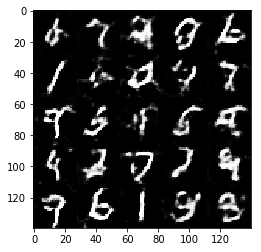

Epoch 1/2... Discriminator Loss: 0.6452... Generator Loss: 2.2097
Epoch 1/2... Discriminator Loss: 0.6850... Generator Loss: 2.0820
Epoch 1/2... Discriminator Loss: 0.7637... Generator Loss: 1.1694
Epoch 1/2... Discriminator Loss: 0.4012... Generator Loss: 1.7868
Epoch 1/2... Discriminator Loss: 0.8750... Generator Loss: 2.1187
Epoch 1/2... Discriminator Loss: 0.6337... Generator Loss: 1.2561
Epoch 1/2... Discriminator Loss: 0.8529... Generator Loss: 1.5136
Epoch 1/2... Discriminator Loss: 0.7134... Generator Loss: 2.1367
Epoch 1/2... Discriminator Loss: 0.7428... Generator Loss: 1.1898
Epoch 1/2... Discriminator Loss: 0.6403... Generator Loss: 1.3034


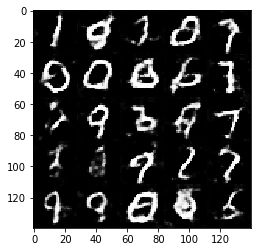

Epoch 1/2... Discriminator Loss: 0.8628... Generator Loss: 0.9082
Epoch 1/2... Discriminator Loss: 0.8303... Generator Loss: 2.0905
Epoch 1/2... Discriminator Loss: 0.5523... Generator Loss: 1.7611
Epoch 1/2... Discriminator Loss: 0.6117... Generator Loss: 1.3148
Epoch 1/2... Discriminator Loss: 0.6772... Generator Loss: 1.6691
Epoch 1/2... Discriminator Loss: 0.7618... Generator Loss: 0.9622
Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 1.9840
Epoch 1/2... Discriminator Loss: 1.0911... Generator Loss: 0.5749
Epoch 1/2... Discriminator Loss: 0.8688... Generator Loss: 1.0179
Epoch 1/2... Discriminator Loss: 0.6565... Generator Loss: 1.2674


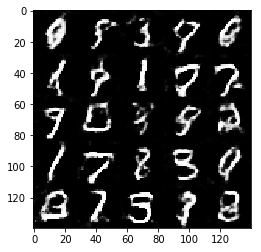

Epoch 1/2... Discriminator Loss: 0.5976... Generator Loss: 1.4469
Epoch 1/2... Discriminator Loss: 0.6207... Generator Loss: 1.1861
Epoch 1/2... Discriminator Loss: 1.2118... Generator Loss: 0.4628
Epoch 1/2... Discriminator Loss: 0.7036... Generator Loss: 1.4872
Epoch 1/2... Discriminator Loss: 1.0666... Generator Loss: 0.5703
Epoch 1/2... Discriminator Loss: 0.9019... Generator Loss: 0.7132
Epoch 1/2... Discriminator Loss: 0.8391... Generator Loss: 0.9057
Epoch 1/2... Discriminator Loss: 0.9452... Generator Loss: 0.6858
Epoch 1/2... Discriminator Loss: 0.6013... Generator Loss: 1.2384
Epoch 1/2... Discriminator Loss: 0.9472... Generator Loss: 1.4646


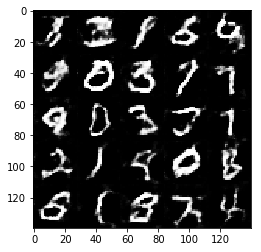

Epoch 1/2... Discriminator Loss: 0.7140... Generator Loss: 1.1937
Epoch 1/2... Discriminator Loss: 0.8323... Generator Loss: 0.8094
Epoch 1/2... Discriminator Loss: 0.4914... Generator Loss: 1.7951
Epoch 1/2... Discriminator Loss: 0.6218... Generator Loss: 1.4386
Epoch 1/2... Discriminator Loss: 0.8858... Generator Loss: 0.8418
Epoch 1/2... Discriminator Loss: 0.8707... Generator Loss: 0.7868
Epoch 1/2... Discriminator Loss: 0.6779... Generator Loss: 1.2245
Epoch 1/2... Discriminator Loss: 0.9231... Generator Loss: 0.7495
Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 2.7483
Epoch 1/2... Discriminator Loss: 0.8737... Generator Loss: 0.8350


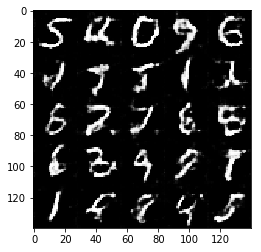

Epoch 1/2... Discriminator Loss: 0.6930... Generator Loss: 1.0916
Epoch 1/2... Discriminator Loss: 1.0323... Generator Loss: 0.6119
Epoch 1/2... Discriminator Loss: 0.6444... Generator Loss: 1.4560
Epoch 1/2... Discriminator Loss: 0.4906... Generator Loss: 1.4416
Epoch 1/2... Discriminator Loss: 0.6613... Generator Loss: 1.0812
Epoch 1/2... Discriminator Loss: 0.4012... Generator Loss: 1.8410
Epoch 1/2... Discriminator Loss: 0.6388... Generator Loss: 1.1482
Epoch 1/2... Discriminator Loss: 0.8103... Generator Loss: 0.7529
Epoch 1/2... Discriminator Loss: 1.0592... Generator Loss: 0.6326
Epoch 1/2... Discriminator Loss: 1.0451... Generator Loss: 0.6507


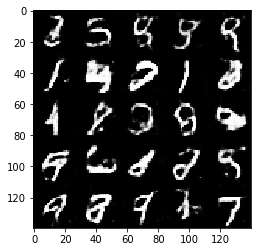

Epoch 1/2... Discriminator Loss: 0.7546... Generator Loss: 1.0435
Epoch 1/2... Discriminator Loss: 0.7569... Generator Loss: 1.8420
Epoch 1/2... Discriminator Loss: 0.4579... Generator Loss: 1.6669
Epoch 1/2... Discriminator Loss: 0.7325... Generator Loss: 2.5108
Epoch 1/2... Discriminator Loss: 1.0321... Generator Loss: 0.6523
Epoch 1/2... Discriminator Loss: 0.8090... Generator Loss: 0.8475
Epoch 1/2... Discriminator Loss: 1.2513... Generator Loss: 0.5126
Epoch 2/2... Discriminator Loss: 1.3889... Generator Loss: 0.3891
Epoch 2/2... Discriminator Loss: 0.4807... Generator Loss: 1.5864
Epoch 2/2... Discriminator Loss: 0.7365... Generator Loss: 0.9200


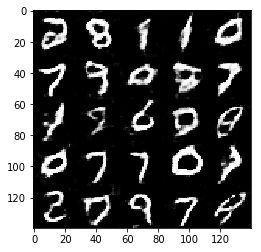

Epoch 2/2... Discriminator Loss: 0.7727... Generator Loss: 0.8307
Epoch 2/2... Discriminator Loss: 0.4347... Generator Loss: 1.4347
Epoch 2/2... Discriminator Loss: 0.5487... Generator Loss: 1.2321
Epoch 2/2... Discriminator Loss: 0.6737... Generator Loss: 1.0206
Epoch 2/2... Discriminator Loss: 0.5272... Generator Loss: 2.6073
Epoch 2/2... Discriminator Loss: 0.9029... Generator Loss: 0.8535
Epoch 2/2... Discriminator Loss: 0.9485... Generator Loss: 0.8950
Epoch 2/2... Discriminator Loss: 0.4842... Generator Loss: 1.4553
Epoch 2/2... Discriminator Loss: 0.5151... Generator Loss: 1.6492
Epoch 2/2... Discriminator Loss: 0.7241... Generator Loss: 0.8969


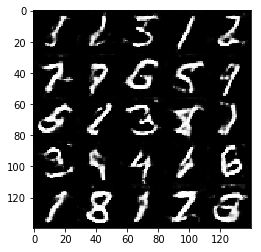

Epoch 2/2... Discriminator Loss: 0.6201... Generator Loss: 1.0124
Epoch 2/2... Discriminator Loss: 0.5281... Generator Loss: 1.3334
Epoch 2/2... Discriminator Loss: 0.4510... Generator Loss: 1.5831
Epoch 2/2... Discriminator Loss: 0.7931... Generator Loss: 1.7514
Epoch 2/2... Discriminator Loss: 0.4272... Generator Loss: 1.7541
Epoch 2/2... Discriminator Loss: 0.5482... Generator Loss: 1.4876
Epoch 2/2... Discriminator Loss: 0.5778... Generator Loss: 1.2471
Epoch 2/2... Discriminator Loss: 0.5320... Generator Loss: 1.1971
Epoch 2/2... Discriminator Loss: 0.6912... Generator Loss: 1.0509
Epoch 2/2... Discriminator Loss: 0.4698... Generator Loss: 1.4552


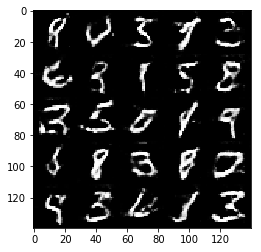

Epoch 2/2... Discriminator Loss: 0.7916... Generator Loss: 0.7830
Epoch 2/2... Discriminator Loss: 0.6545... Generator Loss: 1.0433
Epoch 2/2... Discriminator Loss: 0.8156... Generator Loss: 0.8572
Epoch 2/2... Discriminator Loss: 0.6060... Generator Loss: 1.1064
Epoch 2/2... Discriminator Loss: 1.1837... Generator Loss: 0.4788
Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 0.8198
Epoch 2/2... Discriminator Loss: 0.7942... Generator Loss: 3.8522
Epoch 2/2... Discriminator Loss: 0.4978... Generator Loss: 1.3539
Epoch 2/2... Discriminator Loss: 0.7477... Generator Loss: 1.1046
Epoch 2/2... Discriminator Loss: 0.5896... Generator Loss: 1.3372


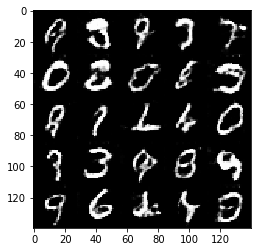

Epoch 2/2... Discriminator Loss: 0.8701... Generator Loss: 0.7315
Epoch 2/2... Discriminator Loss: 0.6911... Generator Loss: 0.9627
Epoch 2/2... Discriminator Loss: 0.7051... Generator Loss: 0.9839
Epoch 2/2... Discriminator Loss: 1.2949... Generator Loss: 0.4936
Epoch 2/2... Discriminator Loss: 0.7438... Generator Loss: 0.8475
Epoch 2/2... Discriminator Loss: 0.7021... Generator Loss: 0.8607
Epoch 2/2... Discriminator Loss: 4.1818... Generator Loss: 7.0392
Epoch 2/2... Discriminator Loss: 0.5991... Generator Loss: 1.7184
Epoch 2/2... Discriminator Loss: 0.7527... Generator Loss: 1.0100
Epoch 2/2... Discriminator Loss: 0.5482... Generator Loss: 1.3288


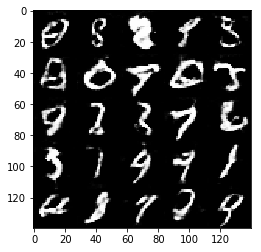

Epoch 2/2... Discriminator Loss: 0.7837... Generator Loss: 0.8844
Epoch 2/2... Discriminator Loss: 1.7502... Generator Loss: 0.3155
Epoch 2/2... Discriminator Loss: 0.5965... Generator Loss: 1.2934
Epoch 2/2... Discriminator Loss: 0.4890... Generator Loss: 1.6297
Epoch 2/2... Discriminator Loss: 0.6091... Generator Loss: 1.2310
Epoch 2/2... Discriminator Loss: 1.1016... Generator Loss: 0.5486
Epoch 2/2... Discriminator Loss: 0.5980... Generator Loss: 2.1181
Epoch 2/2... Discriminator Loss: 0.7249... Generator Loss: 0.9146
Epoch 2/2... Discriminator Loss: 0.6373... Generator Loss: 1.1758
Epoch 2/2... Discriminator Loss: 0.7732... Generator Loss: 0.8351


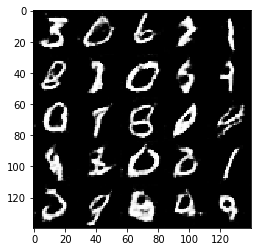

Epoch 2/2... Discriminator Loss: 0.6858... Generator Loss: 0.9249
Epoch 2/2... Discriminator Loss: 0.7275... Generator Loss: 0.9564
Epoch 2/2... Discriminator Loss: 0.4890... Generator Loss: 1.2935
Epoch 2/2... Discriminator Loss: 1.0061... Generator Loss: 0.7192
Epoch 2/2... Discriminator Loss: 0.5990... Generator Loss: 1.2403
Epoch 2/2... Discriminator Loss: 7.0274... Generator Loss: 0.0019
Epoch 2/2... Discriminator Loss: 0.6491... Generator Loss: 1.8349
Epoch 2/2... Discriminator Loss: 0.5866... Generator Loss: 1.0774
Epoch 2/2... Discriminator Loss: 0.4587... Generator Loss: 1.6020
Epoch 2/2... Discriminator Loss: 0.8925... Generator Loss: 0.8336


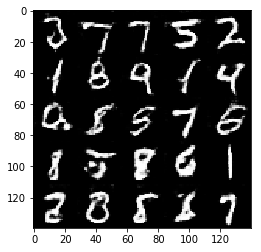

Epoch 2/2... Discriminator Loss: 0.6675... Generator Loss: 1.0933
Epoch 2/2... Discriminator Loss: 0.5105... Generator Loss: 1.5417
Epoch 2/2... Discriminator Loss: 0.7997... Generator Loss: 1.6071
Epoch 2/2... Discriminator Loss: 0.4790... Generator Loss: 1.5022
Epoch 2/2... Discriminator Loss: 0.6621... Generator Loss: 1.0042
Epoch 2/2... Discriminator Loss: 0.5041... Generator Loss: 1.4457
Epoch 2/2... Discriminator Loss: 0.5496... Generator Loss: 1.4144
Epoch 2/2... Discriminator Loss: 0.7269... Generator Loss: 1.1430
Epoch 2/2... Discriminator Loss: 0.6108... Generator Loss: 1.1240
Epoch 2/2... Discriminator Loss: 1.0885... Generator Loss: 0.5371


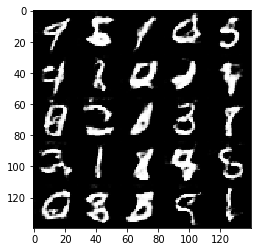

Epoch 2/2... Discriminator Loss: 0.9657... Generator Loss: 0.7810
Epoch 2/2... Discriminator Loss: 0.9704... Generator Loss: 0.7081
Epoch 2/2... Discriminator Loss: 0.4966... Generator Loss: 1.3563
Epoch 2/2... Discriminator Loss: 0.6142... Generator Loss: 1.2543
Epoch 2/2... Discriminator Loss: 0.4393... Generator Loss: 1.6345
Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 2.4569
Epoch 2/2... Discriminator Loss: 0.6922... Generator Loss: 1.0575
Epoch 2/2... Discriminator Loss: 0.8513... Generator Loss: 0.7623
Epoch 2/2... Discriminator Loss: 0.6183... Generator Loss: 1.1405
Epoch 2/2... Discriminator Loss: 0.4406... Generator Loss: 1.4582


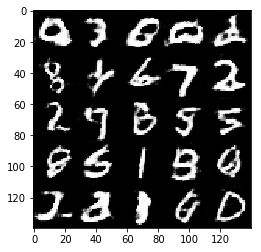

Epoch 2/2... Discriminator Loss: 0.5308... Generator Loss: 1.2679
Epoch 2/2... Discriminator Loss: 0.7252... Generator Loss: 0.9120
Epoch 2/2... Discriminator Loss: 0.8150... Generator Loss: 0.9380
Epoch 2/2... Discriminator Loss: 0.3609... Generator Loss: 1.7554
Epoch 2/2... Discriminator Loss: 0.7245... Generator Loss: 0.9110
Epoch 2/2... Discriminator Loss: 0.8001... Generator Loss: 0.8182
Epoch 2/2... Discriminator Loss: 0.3427... Generator Loss: 1.7846
Epoch 2/2... Discriminator Loss: 1.7687... Generator Loss: 5.0524
Epoch 2/2... Discriminator Loss: 0.6654... Generator Loss: 1.6710
Epoch 2/2... Discriminator Loss: 0.7489... Generator Loss: 0.9407


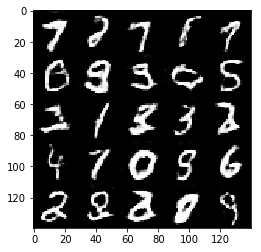

Epoch 2/2... Discriminator Loss: 0.4987... Generator Loss: 1.3472
Epoch 2/2... Discriminator Loss: 1.2304... Generator Loss: 0.4879
Epoch 2/2... Discriminator Loss: 0.3876... Generator Loss: 1.7848
Epoch 2/2... Discriminator Loss: 0.4713... Generator Loss: 1.5918
Epoch 2/2... Discriminator Loss: 0.4249... Generator Loss: 1.6327
Epoch 2/2... Discriminator Loss: 0.4559... Generator Loss: 1.4575
Epoch 2/2... Discriminator Loss: 0.4586... Generator Loss: 1.4999
Epoch 2/2... Discriminator Loss: 0.6115... Generator Loss: 1.0221
Epoch 2/2... Discriminator Loss: 0.8140... Generator Loss: 3.2740
Epoch 2/2... Discriminator Loss: 0.4379... Generator Loss: 1.6819


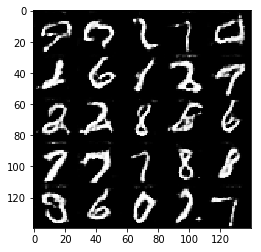

Epoch 2/2... Discriminator Loss: 0.6016... Generator Loss: 1.2748
Epoch 2/2... Discriminator Loss: 0.4378... Generator Loss: 1.4609
Epoch 2/2... Discriminator Loss: 0.4294... Generator Loss: 1.5201
Epoch 2/2... Discriminator Loss: 0.7942... Generator Loss: 0.7659
Epoch 2/2... Discriminator Loss: 1.0906... Generator Loss: 0.6965
Epoch 2/2... Discriminator Loss: 0.6311... Generator Loss: 1.0235
Epoch 2/2... Discriminator Loss: 0.4904... Generator Loss: 1.2652
Epoch 2/2... Discriminator Loss: 0.4762... Generator Loss: 1.4150
Epoch 2/2... Discriminator Loss: 0.6623... Generator Loss: 0.9691
Epoch 2/2... Discriminator Loss: 0.4852... Generator Loss: 1.8576


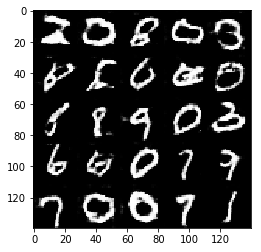

Epoch 2/2... Discriminator Loss: 0.4769... Generator Loss: 1.5371
Epoch 2/2... Discriminator Loss: 0.5553... Generator Loss: 1.4786
Epoch 2/2... Discriminator Loss: 0.7831... Generator Loss: 0.9221
Epoch 2/2... Discriminator Loss: 3.0598... Generator Loss: 0.1461
Epoch 2/2... Discriminator Loss: 0.5702... Generator Loss: 1.4615
Epoch 2/2... Discriminator Loss: 0.3597... Generator Loss: 1.6789
Epoch 2/2... Discriminator Loss: 0.5212... Generator Loss: 1.2167
Epoch 2/2... Discriminator Loss: 0.5503... Generator Loss: 1.3313
Epoch 2/2... Discriminator Loss: 0.3874... Generator Loss: 1.6455
Epoch 2/2... Discriminator Loss: 0.9635... Generator Loss: 0.6760


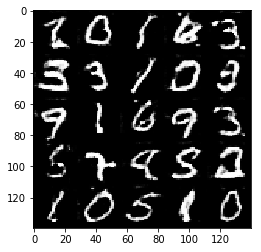

Epoch 2/2... Discriminator Loss: 2.3076... Generator Loss: 0.1801
Epoch 2/2... Discriminator Loss: 0.4911... Generator Loss: 2.0317
Epoch 2/2... Discriminator Loss: 0.5507... Generator Loss: 1.2701
Epoch 2/2... Discriminator Loss: 0.5850... Generator Loss: 1.0924
Epoch 2/2... Discriminator Loss: 0.7101... Generator Loss: 0.8534
Epoch 2/2... Discriminator Loss: 1.0563... Generator Loss: 0.7043
Epoch 2/2... Discriminator Loss: 0.5940... Generator Loss: 1.2375
Epoch 2/2... Discriminator Loss: 1.3210... Generator Loss: 0.4742
Epoch 2/2... Discriminator Loss: 0.6213... Generator Loss: 1.0608
Epoch 2/2... Discriminator Loss: 0.3525... Generator Loss: 1.7998


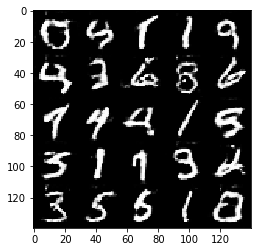

Epoch 2/2... Discriminator Loss: 0.5089... Generator Loss: 1.4218
Epoch 2/2... Discriminator Loss: 0.7975... Generator Loss: 0.9403
Epoch 2/2... Discriminator Loss: 0.6881... Generator Loss: 0.9538
Epoch 2/2... Discriminator Loss: 0.4579... Generator Loss: 1.3461
Epoch 2/2... Discriminator Loss: 0.7003... Generator Loss: 0.9372
Epoch 2/2... Discriminator Loss: 1.5606... Generator Loss: 0.3191
Epoch 2/2... Discriminator Loss: 0.4165... Generator Loss: 1.6309
Epoch 2/2... Discriminator Loss: 0.3033... Generator Loss: 2.0361
Epoch 2/2... Discriminator Loss: 0.4936... Generator Loss: 1.5511
Epoch 2/2... Discriminator Loss: 0.4655... Generator Loss: 2.0230


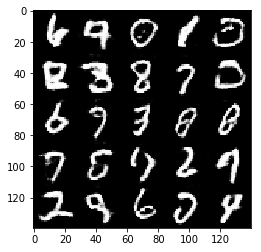

Epoch 2/2... Discriminator Loss: 0.9776... Generator Loss: 0.6898
Epoch 2/2... Discriminator Loss: 0.4697... Generator Loss: 1.2297
Epoch 2/2... Discriminator Loss: 0.5632... Generator Loss: 1.2026
Epoch 2/2... Discriminator Loss: 0.9995... Generator Loss: 0.6222
Epoch 2/2... Discriminator Loss: 0.5505... Generator Loss: 1.1881
Epoch 2/2... Discriminator Loss: 0.7565... Generator Loss: 0.9570
Epoch 2/2... Discriminator Loss: 0.8247... Generator Loss: 0.7858
Epoch 2/2... Discriminator Loss: 0.4628... Generator Loss: 1.4889
Epoch 2/2... Discriminator Loss: 0.8968... Generator Loss: 0.7475
Epoch 2/2... Discriminator Loss: 0.5607... Generator Loss: 2.9154


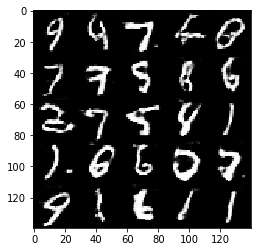

Epoch 2/2... Discriminator Loss: 1.6652... Generator Loss: 3.7026
Epoch 2/2... Discriminator Loss: 1.0347... Generator Loss: 0.6687
Epoch 2/2... Discriminator Loss: 0.6139... Generator Loss: 1.1437
Epoch 2/2... Discriminator Loss: 0.9199... Generator Loss: 0.7433
Epoch 2/2... Discriminator Loss: 0.4086... Generator Loss: 1.3766
Epoch 2/2... Discriminator Loss: 2.1834... Generator Loss: 0.1929
Epoch 2/2... Discriminator Loss: 0.6554... Generator Loss: 1.0749
Epoch 2/2... Discriminator Loss: 0.6336... Generator Loss: 1.0417
Epoch 2/2... Discriminator Loss: 1.0102... Generator Loss: 0.5843
Epoch 2/2... Discriminator Loss: 0.4123... Generator Loss: 1.4174


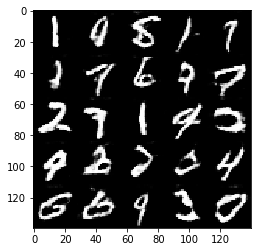

Epoch 2/2... Discriminator Loss: 0.3850... Generator Loss: 1.6681
Epoch 2/2... Discriminator Loss: 0.2520... Generator Loss: 2.5318
Epoch 2/2... Discriminator Loss: 1.0146... Generator Loss: 0.6513
Epoch 2/2... Discriminator Loss: 0.5548... Generator Loss: 1.5300
Epoch 2/2... Discriminator Loss: 0.4906... Generator Loss: 1.4285
Epoch 2/2... Discriminator Loss: 0.8132... Generator Loss: 0.9121
Epoch 2/2... Discriminator Loss: 0.4247... Generator Loss: 1.4977
Epoch 2/2... Discriminator Loss: 0.4534... Generator Loss: 1.4553
Epoch 2/2... Discriminator Loss: 0.5091... Generator Loss: 1.2947
Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 0.6899


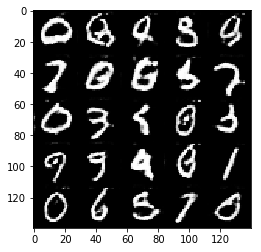

Epoch 2/2... Discriminator Loss: 0.6619... Generator Loss: 1.0772
Epoch 2/2... Discriminator Loss: 0.6132... Generator Loss: 1.2722
Epoch 2/2... Discriminator Loss: 4.4947... Generator Loss: 8.0051
Epoch 2/2... Discriminator Loss: 0.5942... Generator Loss: 1.4219
Epoch 2/2... Discriminator Loss: 0.5406... Generator Loss: 1.2740
Epoch 2/2... Discriminator Loss: 0.6278... Generator Loss: 1.3736
Epoch 2/2... Discriminator Loss: 0.3571... Generator Loss: 1.8083
Epoch 2/2... Discriminator Loss: 0.6092... Generator Loss: 1.0413
Epoch 2/2... Discriminator Loss: 0.3454... Generator Loss: 2.0411
Epoch 2/2... Discriminator Loss: 0.3903... Generator Loss: 1.6106


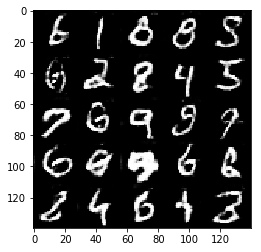

Epoch 2/2... Discriminator Loss: 0.6815... Generator Loss: 1.0207
Epoch 2/2... Discriminator Loss: 1.1894... Generator Loss: 0.6399
Epoch 2/2... Discriminator Loss: 1.5558... Generator Loss: 0.3992
Epoch 2/2... Discriminator Loss: 0.4723... Generator Loss: 1.4942
Epoch 2/2... Discriminator Loss: 0.5983... Generator Loss: 1.2496


In [20]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.5203... Generator Loss: 0.1118
Epoch 1/1... Discriminator Loss: 0.4793... Generator Loss: 1.2375
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 8.7344
Epoch 1/1... Discriminator Loss: 0.4047... Generator Loss: 2.4635
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 8.4933
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 5.9412
Epoch 1/1... Discriminator Loss: 0.5338... Generator Loss: 6.7162
Epoch 1/1... Discriminator Loss: 0.5990... Generator Loss: 2.4356
Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 0.9977
Epoch 1/1... Discriminator Loss: 0.4855... Generator Loss: 1.4827


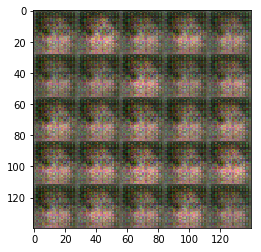

Epoch 1/1... Discriminator Loss: 0.5807... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 0.4561... Generator Loss: 4.4930
Epoch 1/1... Discriminator Loss: 0.5983... Generator Loss: 1.7299
Epoch 1/1... Discriminator Loss: 0.8871... Generator Loss: 2.7119
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.5122
Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.5108
Epoch 1/1... Discriminator Loss: 0.9005... Generator Loss: 3.0486
Epoch 1/1... Discriminator Loss: 0.6625... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 0.7422


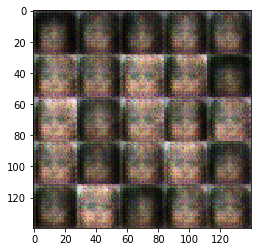

Epoch 1/1... Discriminator Loss: 1.9198... Generator Loss: 0.2462
Epoch 1/1... Discriminator Loss: 0.7547... Generator Loss: 1.8766
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 2.2142
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 1.0266
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 0.5381
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 1.1717
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 2.1120
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 2.1524


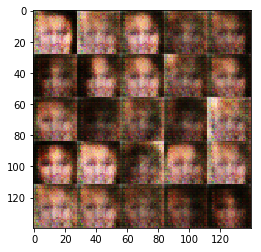

Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 1.3777
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 1.6362
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 1.6304
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 2.7890
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 1.0986
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 1.2990


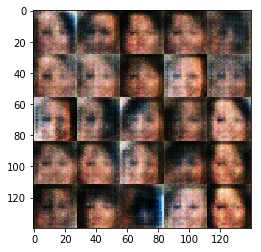

Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.4897
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 1.4173
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 1.5390
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 0.8705... Generator Loss: 1.5949


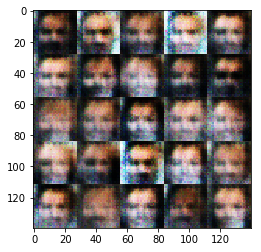

Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 2.6256
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 1.5157
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 1.1679
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 1.9938
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 1.3831
Epoch 1/1... Discriminator Loss: 1.7641... Generator Loss: 0.2876
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 1.1500


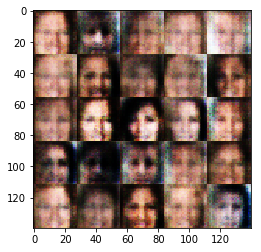

Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 1.4785
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 0.8364... Generator Loss: 1.3338
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.5069
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 1.4020
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 1.1063


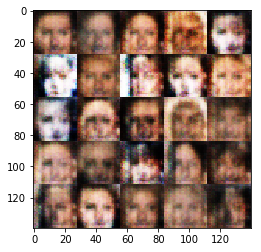

Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 1.1843
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 1.5032
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.5925... Generator Loss: 0.4031
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 1.3369
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.7580


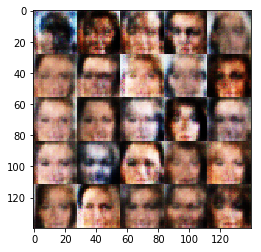

Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.4885
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.5644
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 1.0941
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 1.3686
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 1.5047


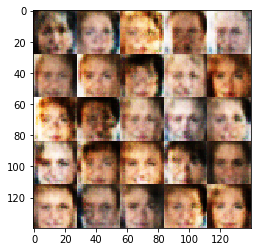

Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.6632... Generator Loss: 0.3411
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.7414


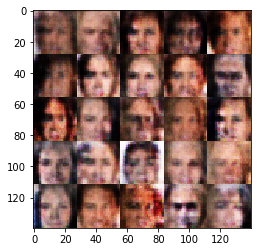

Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 1.5912
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 1.5727
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.3686
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.7680... Generator Loss: 0.2697
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 1.3552


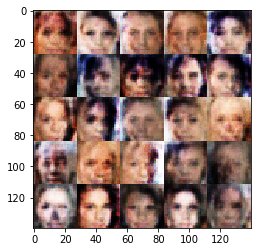

Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 1.1282
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 1.4764
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 1.4592
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 1.7110
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 1.1181
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.6900... Generator Loss: 0.2952
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.5575


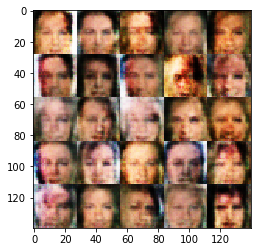

Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 1.1369
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.4714
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.4085
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 1.2437
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 2.9039
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.5268


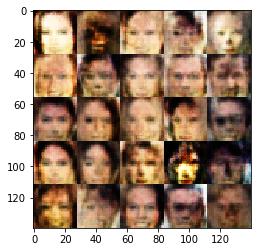

Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 1.5271
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 1.8669
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.5491
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 2.2550
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 2.2268
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.4561
Epoch 1/1... Discriminator Loss: 1.9335... Generator Loss: 0.1998
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.4620


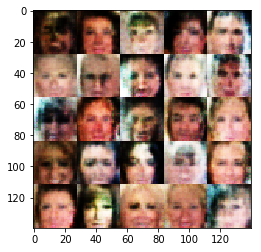

Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 1.8306
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.6939... Generator Loss: 0.2804
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.3190
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 1.5529
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.4176


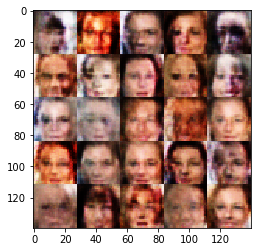

Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 1.5024
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 1.0226
Epoch 1/1... Discriminator Loss: 0.8781... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.3532
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 1.6571
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 1.2918
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 0.8602


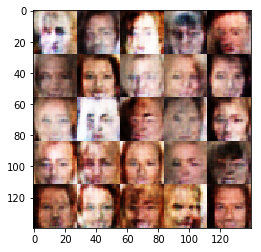

Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 0.7057... Generator Loss: 1.2344
Epoch 1/1... Discriminator Loss: 0.7983... Generator Loss: 1.4835
Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 1.8803
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.5395
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 1.1456
Epoch 1/1... Discriminator Loss: 1.7597... Generator Loss: 0.2583
Epoch 1/1... Discriminator Loss: 0.7224... Generator Loss: 1.2438
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 1.1679


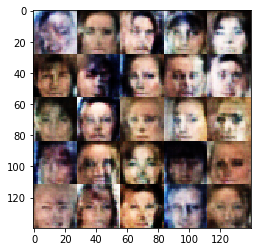

Epoch 1/1... Discriminator Loss: 1.8096... Generator Loss: 0.2483
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 2.3161
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 1.2539
Epoch 1/1... Discriminator Loss: 0.6480... Generator Loss: 1.6349
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.1134
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.5474
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.5149
Epoch 1/1... Discriminator Loss: 1.6985... Generator Loss: 0.2665
Epoch 1/1... Discriminator Loss: 0.6904... Generator Loss: 1.6719
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 1.2293


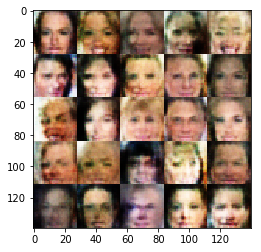

Epoch 1/1... Discriminator Loss: 0.6625... Generator Loss: 1.3611
Epoch 1/1... Discriminator Loss: 1.7019... Generator Loss: 0.2675
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 0.7331... Generator Loss: 1.2687
Epoch 1/1... Discriminator Loss: 1.8690... Generator Loss: 0.2156
Epoch 1/1... Discriminator Loss: 0.5894... Generator Loss: 1.2523
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 1.4406
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 2.1857


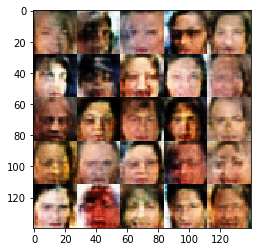

Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 1.2721
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 2.0719
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 1.5609
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 2.0006
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 1.3403
Epoch 1/1... Discriminator Loss: 0.9782... Generator Loss: 1.3410
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 1.3503
Epoch 1/1... Discriminator Loss: 1.8556... Generator Loss: 0.2478


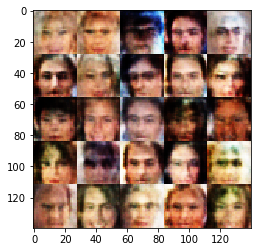

Epoch 1/1... Discriminator Loss: 1.6202... Generator Loss: 0.2691
Epoch 1/1... Discriminator Loss: 0.7541... Generator Loss: 2.9309
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 1.4132
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.3886
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.4063


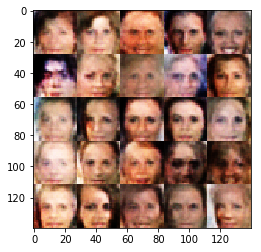

Epoch 1/1... Discriminator Loss: 0.8605... Generator Loss: 1.3537
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 2.0823... Generator Loss: 0.1699
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 0.6319... Generator Loss: 1.7194
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 2.0885
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 1.5394
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 2.3730
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.5514


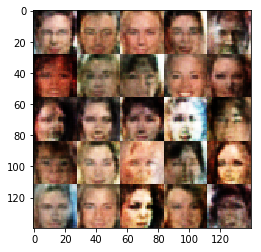

Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 1.2888
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 1.8215
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.5888
Epoch 1/1... Discriminator Loss: 1.5567... Generator Loss: 0.3199
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 1.2903
Epoch 1/1... Discriminator Loss: 2.2471... Generator Loss: 0.1306


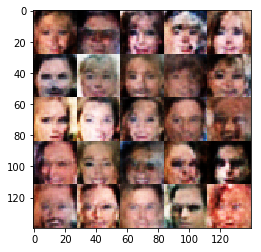

Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 3.2575
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 0.9529
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 1.9857
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.4910
Epoch 1/1... Discriminator Loss: 1.7149... Generator Loss: 0.2440
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 1.7123
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 1.9238... Generator Loss: 0.1996


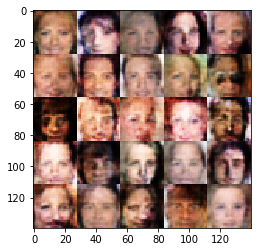

Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 1.8289
Epoch 1/1... Discriminator Loss: 1.6565... Generator Loss: 0.2728
Epoch 1/1... Discriminator Loss: 0.7653... Generator Loss: 2.1660
Epoch 1/1... Discriminator Loss: 0.5730... Generator Loss: 1.4265
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.3097
Epoch 1/1... Discriminator Loss: 1.7568... Generator Loss: 0.2483
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.4389
Epoch 1/1... Discriminator Loss: 0.7041... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.5661


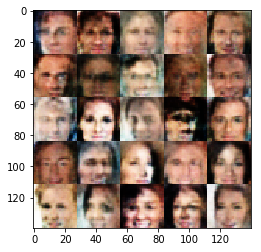

Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 1.3712
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 2.5604
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 2.1421... Generator Loss: 0.1588
Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 1.1735
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 1.3528
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 0.6310


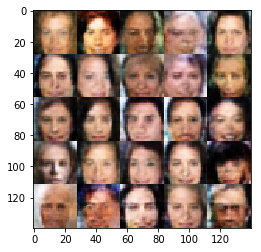

Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.8824... Generator Loss: 0.1995
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 1.7874
Epoch 1/1... Discriminator Loss: 0.7549... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.4148
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 1.8939
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 0.7118... Generator Loss: 1.5136
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.7876


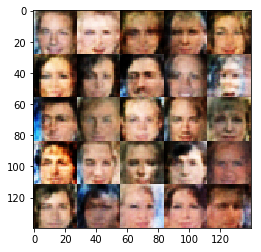

Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.4964
Epoch 1/1... Discriminator Loss: 0.8740... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.3505
Epoch 1/1... Discriminator Loss: 2.0483... Generator Loss: 0.1771
Epoch 1/1... Discriminator Loss: 0.3991... Generator Loss: 2.0325
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.4270
Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 1.5390
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 0.5338


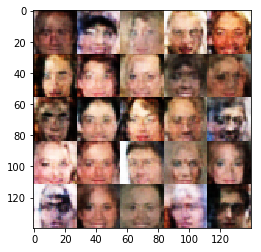

Epoch 1/1... Discriminator Loss: 0.9225... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 1.7824... Generator Loss: 0.2243
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.6121
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.3654
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.4425
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.4389
Epoch 1/1... Discriminator Loss: 0.6709... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.6694


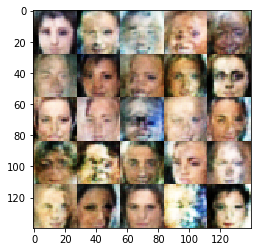

Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.3202
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 1.7663
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.5566
Epoch 1/1... Discriminator Loss: 1.6436... Generator Loss: 0.2745
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 1.4539
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 1.2034
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.3359


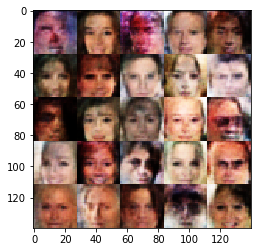

Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 1.1083
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.4526
Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 0.8091... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.3317
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.8404


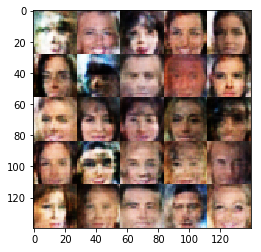

Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.5177
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.4064
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.4599
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.4220
Epoch 1/1... Discriminator Loss: 0.8882... Generator Loss: 1.3239
Epoch 1/1... Discriminator Loss: 1.6987... Generator Loss: 0.2628
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.4452
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 1.5626
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 0.6500


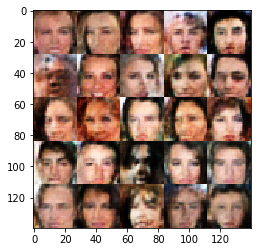

Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.2541
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 1.1399
Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 0.9020
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 1.1675
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.4067
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.5195
Epoch 1/1... Discriminator Loss: 0.5589... Generator Loss: 1.4243
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.8769


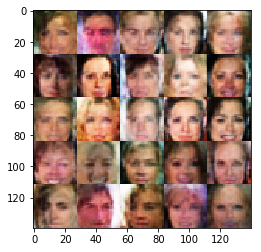

Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 0.8183... Generator Loss: 1.5363
Epoch 1/1... Discriminator Loss: 0.9078... Generator Loss: 1.2138
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 1.4296
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.8556


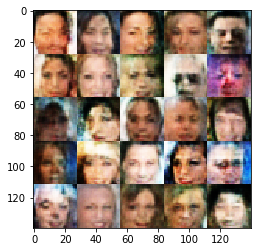

Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 1.0700
Epoch 1/1... Discriminator Loss: 0.6469... Generator Loss: 1.3988
Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 1.2894
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.3729
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.3407
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.4111
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 0.8087... Generator Loss: 1.3679


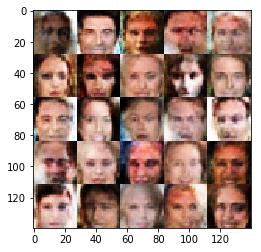

Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 0.7791... Generator Loss: 1.1314
Epoch 1/1... Discriminator Loss: 1.8500... Generator Loss: 0.2199
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.3939
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 1.0847
Epoch 1/1... Discriminator Loss: 0.8490... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.4469


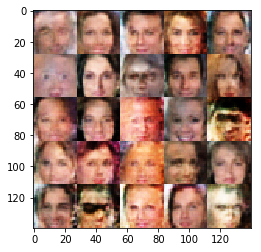

Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.1343
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 1.7722
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 1.1618
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.3460
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.5036
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 1.1189
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.4669


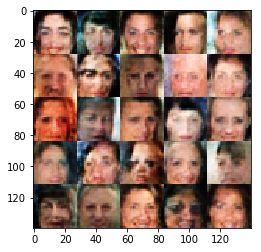

Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 0.8926... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 1.9536
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.5654


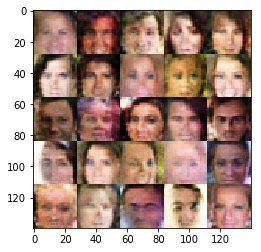

Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 0.6826... Generator Loss: 1.5758
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 1.3750
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 0.7623... Generator Loss: 1.6436
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.5139


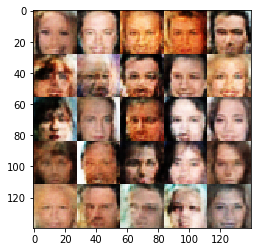

Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 1.3805
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.4495
Epoch 1/1... Discriminator Loss: 0.6976... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 1.4635
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.4586
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.5095
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 1.6719


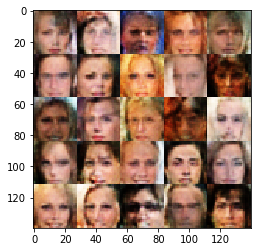

Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.2244
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 1.0024
Epoch 1/1... Discriminator Loss: 0.7624... Generator Loss: 1.2669
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.4284
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 0.8058... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.3442
Epoch 1/1... Discriminator Loss: 1.9112... Generator Loss: 0.2020
Epoch 1/1... Discriminator Loss: 0.8019... Generator Loss: 1.6308


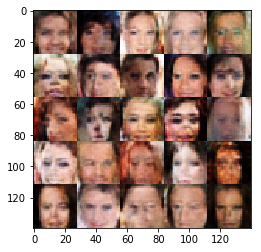

Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.3719
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 1.0663
Epoch 1/1... Discriminator Loss: 0.7776... Generator Loss: 1.3211
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.7403... Generator Loss: 0.2260
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.5028
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 1.7396... Generator Loss: 0.2204


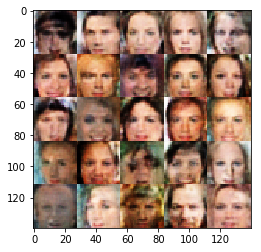

Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 1.4671
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 1.9621
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.3560
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 1.4451
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.5030


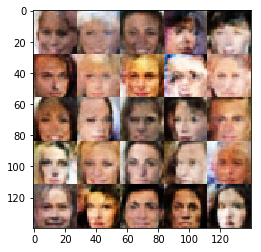

Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.7119... Generator Loss: 0.2512
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 1.7833
Epoch 1/1... Discriminator Loss: 0.7011... Generator Loss: 0.9398
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 2.1141
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.5206
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 0.9880


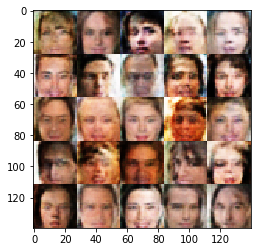

Epoch 1/1... Discriminator Loss: 0.8396... Generator Loss: 1.2647
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.3644
Epoch 1/1... Discriminator Loss: 1.6579... Generator Loss: 0.2662
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.5375
Epoch 1/1... Discriminator Loss: 0.7066... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 0.7077... Generator Loss: 1.3163


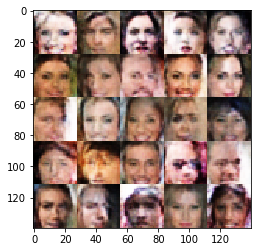

Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.4943
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 1.2447
Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 0.3189
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.4396
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.3501
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 1.2434


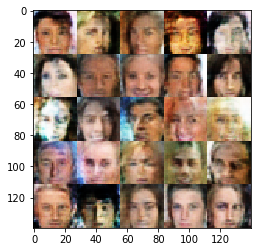

Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.4119
Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 1.6149
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.3235
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 0.6855... Generator Loss: 1.8975
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.1180
Epoch 1/1... Discriminator Loss: 0.8968... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 1.8717
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.4510


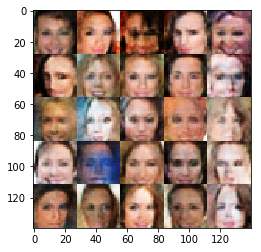

Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 1.2196
Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 1.1705
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.3496
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 0.6065... Generator Loss: 1.1345
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.3310
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.4010
Epoch 1/1... Discriminator Loss: 0.7926... Generator Loss: 0.9772


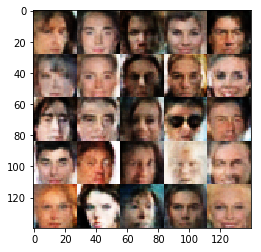

Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 1.2154
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 0.8318... Generator Loss: 1.3123
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.5239
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.3570
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 0.8968... Generator Loss: 0.7450


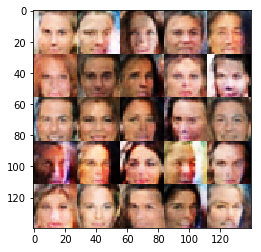

Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 1.1998
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.7358
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.6791... Generator Loss: 2.2227
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 0.5726... Generator Loss: 1.4123
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.4800
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 0.6955


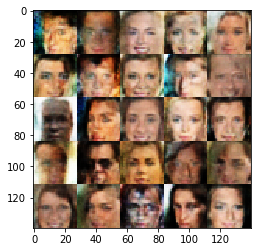

Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.4845
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.4618
Epoch 1/1... Discriminator Loss: 0.6945... Generator Loss: 1.1322
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 2.1384
Epoch 1/1... Discriminator Loss: 0.8396... Generator Loss: 1.4293
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 0.6228... Generator Loss: 1.4757
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 0.7014


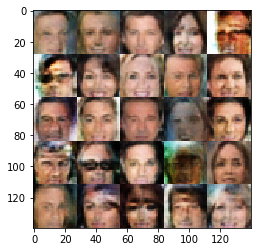

Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.6000
Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 1.0724
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 0.7327... Generator Loss: 1.1029
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.4750
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 1.2168
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 0.7032


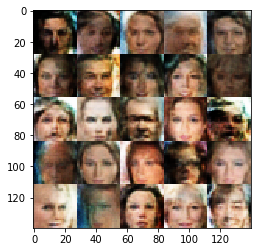

Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 1.4765
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.4897
Epoch 1/1... Discriminator Loss: 0.7321... Generator Loss: 1.0484
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 1.4918
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.5012
Epoch 1/1... Discriminator Loss: 0.9305... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.3526
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 1.1158


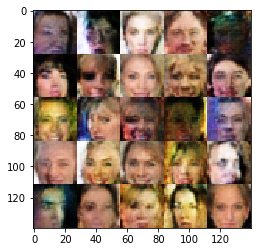

Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 0.9794
Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 0.8662... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.5806... Generator Loss: 0.2683
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.6392... Generator Loss: 0.3440
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 0.7325


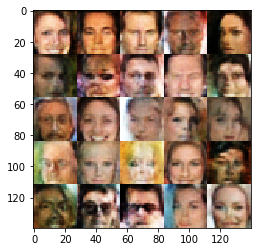

Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 0.6052... Generator Loss: 1.7469
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.4946
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.7338... Generator Loss: 0.2665
Epoch 1/1... Discriminator Loss: 1.8546... Generator Loss: 0.2125
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.4643
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.5508
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.3956


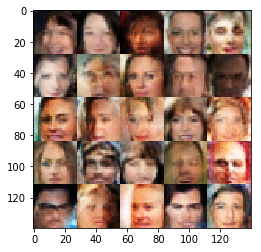

Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.4822
Epoch 1/1... Discriminator Loss: 0.8240... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 1.0689
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.3587
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.4432
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.4467
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.9242
Epoch 1/1... Discriminator Loss: 0.7284... Generator Loss: 1.2626
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.4714


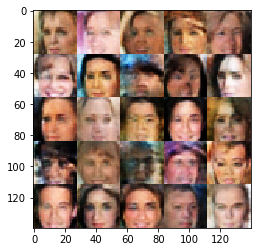

Epoch 1/1... Discriminator Loss: 1.9001... Generator Loss: 0.2062
Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.5378
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.4106
Epoch 1/1... Discriminator Loss: 0.8223... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.5642... Generator Loss: 0.2871
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.4867
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 1.3931
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.4460


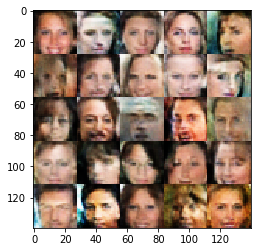

Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.4984
Epoch 1/1... Discriminator Loss: 1.8432... Generator Loss: 0.2142
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.5412
Epoch 1/1... Discriminator Loss: 0.6510... Generator Loss: 1.6746
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 1.5029


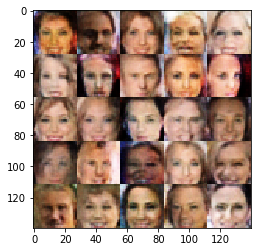

Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 1.3242
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 1.8661
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.4108
Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 1.1614
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.2074
Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 1.1160


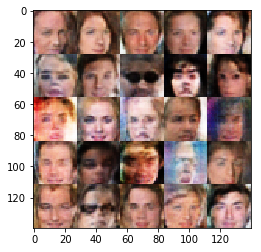

Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.3267
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.5308
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 1.4423
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 0.2933
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.4150
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.3793


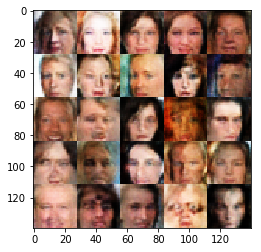

Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 1.1773
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.5273
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.6217... Generator Loss: 0.2686
Epoch 1/1... Discriminator Loss: 0.7785... Generator Loss: 1.0409
Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 1.8000... Generator Loss: 0.2113
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.3193
Epoch 1/1... Discriminator Loss: 0.6892... Generator Loss: 1.3437


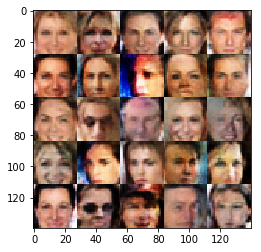

Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.4094
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 1.6818... Generator Loss: 0.2991
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.5603
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.4455
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 1.1738
Epoch 1/1... Discriminator Loss: 0.8063... Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 1.2412
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.3321


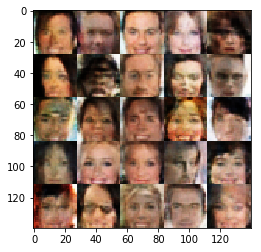

Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.4776
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 0.8729... Generator Loss: 1.2757
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 1.1261
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.4597
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 1.2499
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.5026
Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.7630


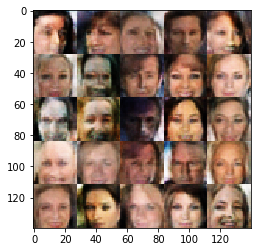

Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 0.7766


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.